# Disaster tweets prediction

Determining the subject and content of text data is an important process researchers are improving every day. We want to be able to programmatically derive understanding from text. The goal of this project is to determine if tweets are about a natural disaster as part of [this](https://www.kaggle.com/competitions/nlp-getting-started) kaggle competition. The project will use word embeddings and deep learning models to make these predictions. My notebook has the following structure:
- EDA
- Data preprocessing
- Model architecture
- Hyperparameter tuning
- Results and analysis
- Conclusion

In [7]:
#makes it possible to access nltk data on kaggle
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [31]:
#imports
import collections
import keras
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns

from keras import layers
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

## EDA

We are given a dataframe with a few features and 7,613 observations for a size of 5 x 7,613. I will be working with the text column to predict the target. Below is a look at the first few rows of the train dataset, as well as information about the dataset as a whole.

In [9]:
#read in data
df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
#what's in the box?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Before I explore my dataset, I need to clean up the text data using a few different techniques. I will perform the following steps:
- Lowercase the text
- Remove everything but letters
- Tokenize
- Remove stopwords
- Lemmatize words

Vectorized operations in pandas make cleanup a breeze!

In [11]:
#lowercase the text
df.text = df.text.str.lower()

In [12]:
#use regex to remove everything but letters and spaces
regexp = r'[^a-z\s]'
df.text = df.text.str.replace(regexp, '', regex=True)

In [13]:
#get stopwords (making sure not to overwrite stopwords variable)
stpwrds = stopwords.words('english')
#create lemmatizer
lemmatizer = WordNetLemmatizer()
#define function to apply to dataframe
def prepare_text(tweet, stopwords=stpwrds, lmtz=lemmatizer):
    #empty list for approved words
    lemmas = []
    #break text into words
    words = word_tokenize(tweet)
    for word in words:
        #if stopword, don't bother
        if word in stopwords:
            continue
        #else, lemmatize word and add to lemmas
        else:
            lemma = lmtz.lemmatize(word)
            lemmas.append(lemma)
    #return the rejoined lemmas as one tweet
    return ' '.join(lemmas)

#apply function to text column
df.text = df.text.apply(prepare_text)

In [14]:
#look at cleaned up text
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,resident asked shelter place notified officer ...,1
3,6,NaN,NaN,people receive wildfire evacuation order calif...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfire pour...,1


As you can see, the text is much cleaner and ready for exploration. I will explore the following aspects of my dataset:
- Proportion of target labels
- Commonly occurring bi/trigrams for positive labels
- Commonly occurring bi/trigrams for negative labels

In [15]:
#basic value counts
counts = df.target.value_counts().reset_index()
counts

,target,count
0,0,4342
1,1,3271


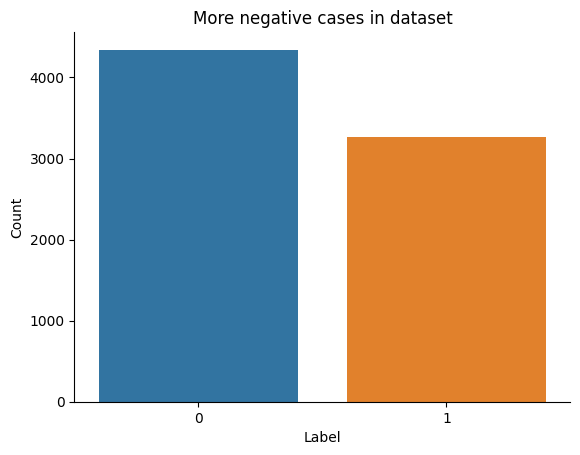

In [16]:
#use value counts to make bar plot
sns.barplot(counts, x='target', y='count')
sns.despine()
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('More negative cases in dataset')
plt.show()

As you can see from the table and bar plot, there are more negative (not natural disaster) cases in the dataset. The difference isn't so significant, however, that I should deviate from a normal approach to this problem. There is no need to attempt to rebalance the classes.

Next I will explore commonly occurring short phrases (bigrams and trigrams) for the positive and negative labels in my dataset.

In [17]:
#join all words with both sets of labels and tokenize
pos_words = word_tokenize(' '.join(df[df.target == 1].text))
neg_words = word_tokenize(' '.join(df[df.target == 0].text))

Using the nltk library, I see an opportunity to create a couple reuseable functions for all my needs.

In [18]:
#function to make bigram plot
def top_ngrams(words, n):
    #prepare top 10 ngrams
    ngrams = nltk.ngrams(words, n)
    top_ten = collections.Counter(ngrams).most_common(10)
    #loop through and save info
    extracted_info = []
    for bg in top_ten:
        #join the phrase together and capitalize first letter
        phrase = ' '.join(bg[0]).capitalize()
        num = bg[1]
        #store info in dict, add to list
        info_dict = {'Phrase': phrase, 'Count': num}
        extracted_info.append(info_dict)
    #return dataframe from list of dictionaries
    return pd.DataFrame(extracted_info)

In [19]:
pos_bigrams = top_ngrams(pos_words, 2)
pos_trigrams = top_ngrams(pos_words, 3)
neg_bigrams = top_ngrams(neg_words, 2)
neg_trigrams = top_ngrams(neg_words, 3)

In [20]:
#basic function to make horizontal bar plot
def plot_ngrams(df, title):
    sns.barplot(df, x='Count', y='Phrase')
    sns.despine()
    plt.title(title)
    plt.show()

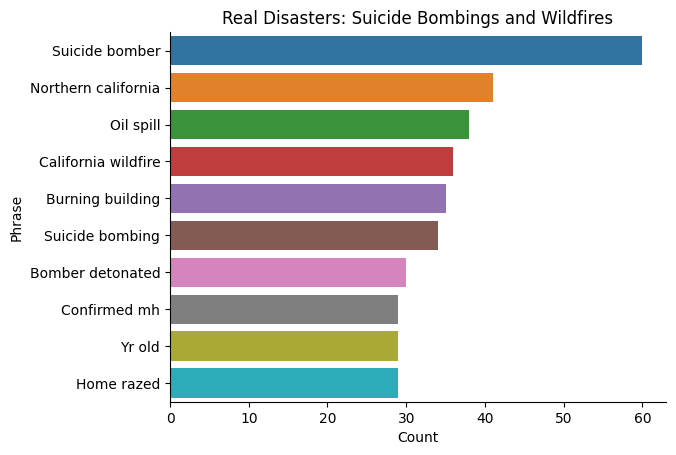

In [21]:
plot_ngrams(pos_bigrams, 'Real Disasters: Suicide Bombings and Wildfires')

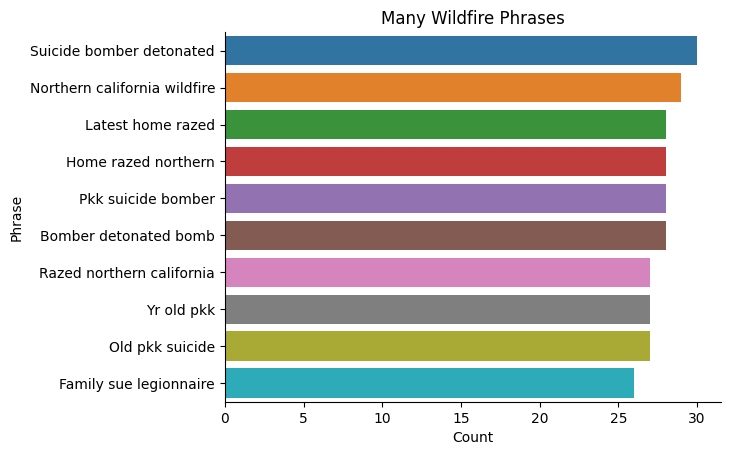

In [22]:
plot_ngrams(pos_trigrams, 'Many Wildfire Phrases')

From the bi/trigrams generated from the positively labeled tweets, we see many references to suicide bombings and wildfires in California. I'm curious to see if this will contrast with the tweets that aren't about natural disasters.

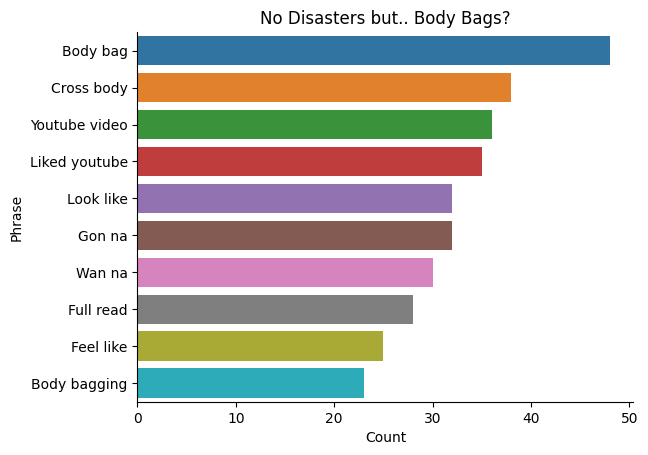

In [23]:
plot_ngrams(neg_bigrams, 'No Disasters but.. Body Bags?')

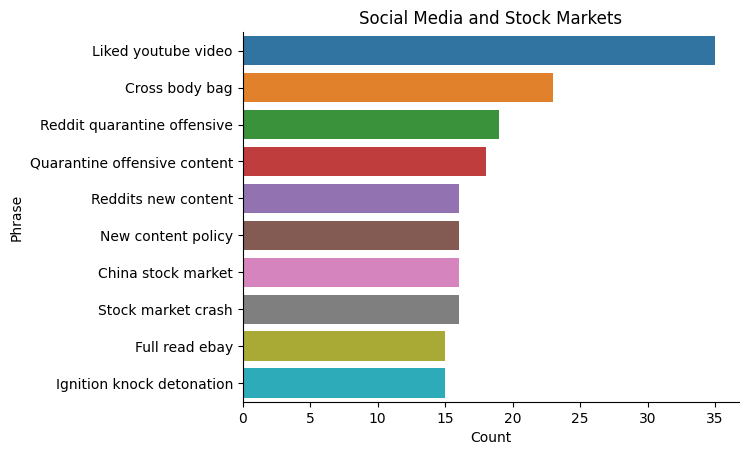

In [24]:
plot_ngrams(neg_trigrams, 'Social Media and Stock Markets')

Not sure why so many tweets in the negative subset reference body bags.. Could this be from a video game or some other reference I don't understand? The trigrams are more clear: tweets not about natural disasters tend to focus on social media and the stock market.

Now that I know a bit more about my dataset, I'm ready to move to data preprocessing before modeling.

## Data preprocessing

For preprocessing, I will rely on the Tokenizer object from the keras text preprocessing module. It allows me to define a vocabulary size and convert my words into numbers. From there, I will use the sequence padding function to make sure all inputs will be the same length. My transformed tweets of identical length will be fed into an embedding layer as the first part of every model. These embeddings will be learned and trained as part of the model. The result from this layer will be passed to further layers for analysis.

In [73]:
#define this for use later in modeling as well
vocab_size = 1_024
#create tokenizer object and fit to text
tknzr = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tknzr.fit_on_texts(df.text)
tknzr.word_index['police']

21

Now the most common 1,024 words in my dataset are represented as numbers. For example, the word 'police' is represented by the number 21. I will use the tokenizer object to convert my words to numbers and pad the sequences so they are all the same length. Since I don't think tweets are very long, I will choose to have a sequence length of 16 words for every tweet. The homogenized length of input will make it possible to train my machine learning models.

In [98]:
#define for use later as well
seq_length = 16
#transform words to numbers and pad sequences to 16
seqs = tknzr.texts_to_sequences(df.text)
padded = pad_sequences(seqs, padding='post', maxlen=seq_length)
padded[:5]

array([[  1, 456, 157,  71,   1,   1,   6,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [109,   2, 149, 483,   1,   1,   1,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  1,   1,   1, 457,   1, 322, 163,   1, 457, 365, 960,   0,   0,
          0,   0,   0],
       [ 12,   1,  78, 163, 365,  33,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [ 32,   1, 113,   1,   1, 189,  78,   1,  98,   0,   0,   0,   0,
          0,   0,   0]], dtype=int32)

As you can see, each entry in my array (representing a tweet) is length 16 and contains a bunch of numbers. The 0's represent padding, the 1's represent out of vocabulary (a word that wasn't in the 1,024 more common words), and the other integers represent commonly occurring words. With my sequences ready for modeling, I will move on to the modeling section of the project!

## Model architecture

I will construct, train, and evaluate some recursive neural networks. I will try the following types of layers:
- GRU
- LSTM
- Bi-directional LSTM

I will determine the best type of recursive model to use for hyperparameter tuning! Before I get into model training and evaluation, I will define a couple useful functions to quickly compare model performances.

In [117]:
#function to get best model metrics
def get_perf(histories, models):
    metrics = []
    #iterate through histories with corresponding models
    for history, model in zip(histories, models):
        #create series and retrieve metrics
        val_series = pd.Series(history.history['val_accuracy'])
        val_acc = val_series.max()
        epoch = val_series.idxmax()
        train_acc = history.history['accuracy'][epoch]
        #make dictionary for train and add to dict
        train_dict = {'Model': model, 'Subset': 'Train', 'Accuracy': train_acc}
        metrics.append(train_dict)
        #make dictionary for val and add to dict
        val_dict = {'Model': model, 'Subset': 'Validate', 'Accuracy': val_acc}
        metrics.append(val_dict)
    #return dataframe of results    
    return pd.DataFrame(metrics)    

In [121]:
#plots best model iterations for comparison
def bar_chart(history):
    fig = sns.barplot(history, x='Model', y='Accuracy', hue='Subset')
    #moves legend off chart permanently
    sns.move_legend(fig, 'upper left', bbox_to_anchor=(1,1))
    sns.despine()

My general model architecture will remain consistent across all trials and will look like this:
- Embedding
- Type of RNN (GRU, LSTM, etc)
- Dense layer(s)
- Output node with sigmoid activation

I need to have the embedding layer so I can develop context for the words in my dataset. Currently, they are integers from 1-1,024. My embedding layer will develop meaning for the words during training. I've chosen to use a type of RNN layer in my model because tweets are sequential: current words may have enhanced/different meaning based on previous words in the tweet. I want a layer that can preserve some information from earlier in the sequence. I want at least one dense layer to interpret the information produced by the recurrent layer. After one or more dense layers, I will finish with a single output node with sigmoid activation. It will have sigmoid activation because I am doing a binary classification project. Let's see what works!

In [114]:
#define basic model
gru = keras.Sequential([
    layers.Embedding(vocab_size, 16),
    layers.GRU(32, activation='leaky_relu'),
    layers.Dense(16, activation='leaky_relu'),
    layers.Dense(1, activation='sigmoid')
])
#compile and train
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gru_hist = gru.fit(padded, df.target, batch_size=128, epochs=100, validation_split=0.2, verbose=0, callbacks=[callback])

Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.


In [115]:
#define basic model
lstm = keras.Sequential([
    layers.Embedding(vocab_size, 16),
    layers.LSTM(32, activation='leaky_relu'),
    layers.Dense(16, activation='leaky_relu'),
    layers.Dense(1, activation='sigmoid')
])
#compile and train
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_hist = gru.fit(padded, df.target, batch_size=128, epochs=100, validation_split=0.2, verbose=0, callbacks=[callback])

Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


In [116]:
#define basic model
bid = keras.Sequential([
    layers.Embedding(vocab_size, 16),
    layers.Bidirectional(
        layers.LSTM(32, activation='leaky_relu')
    ),
    layers.Dense(16, activation='leaky_relu'),
    layers.Dense(1, activation='sigmoid')
])
#compile and train
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
bid.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
bid_hist = gru.fit(padded, df.target, batch_size=128, epochs=100, validation_split=0.2, verbose=0, callbacks=[callback])

Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


In [118]:
archs = get_perf([gru_hist, lstm_hist, bid_hist], ['GRU', 'LSTM', 'Bi-directional LSTM'])
archs

,Model,Subset,Accuracy
0,GRU,Train,0.750903
1,GRU,Validate,0.788575
2,LSTM,Train,0.814286
3,LSTM,Validate,0.793171
4,Bi-directional LSTM,Train,0.832512
5,Bi-directional LSTM,Validate,0.784636


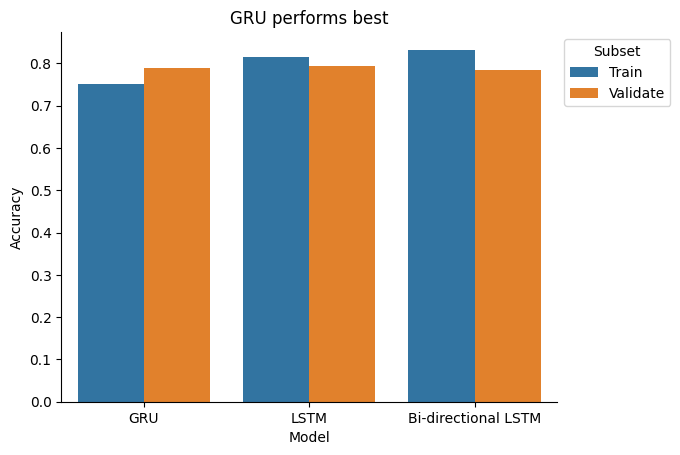

In [164]:
#call bar chart and add title
bar_chart(archs)
plt.title('GRU performs best')
plt.show()

## Hyperparameter tuning

Even though LSTM technically performs better than GRU, I encountered a devastating problem with the LSTM model. For some reason, even though it was scoring well on train and validate accuracy, it returned abysmal predictions when the "predict" method was called. Every value was 0.49. For this reason, I am carrying forward with the GRU model for all future hyperparameter tuning steps. I will attempt to optimize my model in the following ways:
- **Increasing/decreasing size of GRU layer**
- Adding second GRU layer
- Increasing size/number of dense layers
- Introduce small amount of regularization (dropout)

In [165]:
#define model with larger lstm layer
grub = keras.Sequential([
    layers.Embedding(vocab_size, 16),
    layers.GRU(64, activation='leaky_relu'),
    layers.Dense(16, activation='leaky_relu'),
    layers.Dense(1, activation='sigmoid')
])
#compile and train
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
grub.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
grub_hist = gru.fit(padded, df.target, batch_size=128, epochs=100, validation_split=0.2, verbose=0, callbacks=[callback])

Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


In [166]:
#define model with smaller lstm layer
grus = keras.Sequential([
    layers.Embedding(vocab_size, 16),
    layers.GRU(16, activation='leaky_relu'),
    layers.Dense(16, activation='leaky_relu'),
    layers.Dense(1, activation='sigmoid')
])
#compile and train
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
grus.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
grus_hist = gru.fit(padded, df.target, batch_size=128, epochs=100, validation_split=0.2, verbose=0, callbacks=[callback])

Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


In [167]:
width = get_perf([gru_hist, grub_hist, grus_hist], ['Size 32', 'Size 64', 'Size 16'])
width

,Model,Subset,Accuracy
0,Size 32,Train,0.750903
1,Size 32,Validate,0.788575
2,Size 64,Train,0.877340
3,Size 64,Validate,0.755089
4,Size 16,Train,0.879475
5,Size 16,Validate,0.742613


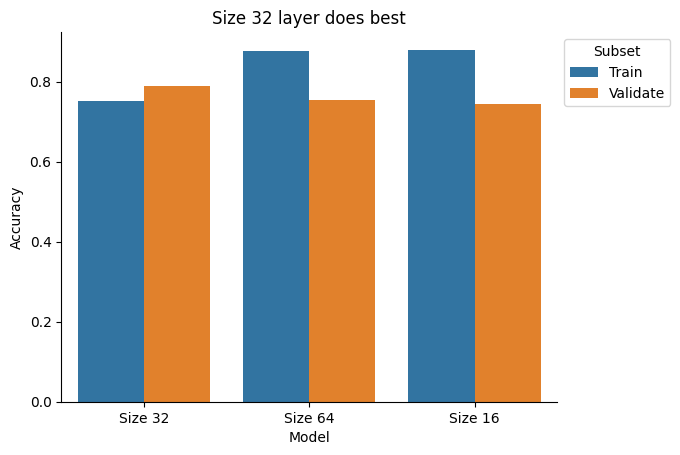

In [168]:
#plot
bar_chart(width)
plt.title('Size 32 layer does best')
plt.show()

This keeps happening to me in my machine learning projects. I try an initial model architecture that performs better than most alternatives as I work through hyperparameter tuning. I think I keep getting lucky. Changing the size of the GRU layer makes the models look more overfit. For some reason, the original model performs even better on out-of-sample data than it does on the training data. I will continue to use the model with 32 units in the GRU layer.

- Increasing/decreasing size of GRU layer
- **Adding second GRU layer**
- Increasing size/number of dense layers
- Introduce small amount of regularization (dropout)

In [174]:
#define model with 2 lstm layers
grut = keras.Sequential([
    layers.Embedding(vocab_size, 16),
    layers.GRU(32, activation='leaky_relu'),
    layers.GRU(16, activation='leaky_relu'),
    layers.Dense(16, activation='leaky_relu'),
    layers.Dense(1, activation='sigmoid')
])
#compile and train
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
grut.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
grut_hist = gru.fit(padded, df.target, batch_size=128, epochs=100, validation_split=0.2, verbose=0, callbacks=[callback])

Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


In [175]:
#generate df
two_gru = get_perf([gru_hist, grut_hist], ['One layer', 'Two layers'])
two_gru

,Model,Subset,Accuracy
0,One layer,Train,0.750903
1,One layer,Validate,0.788575
2,Two layers,Train,0.880624
3,Two layers,Validate,0.745896


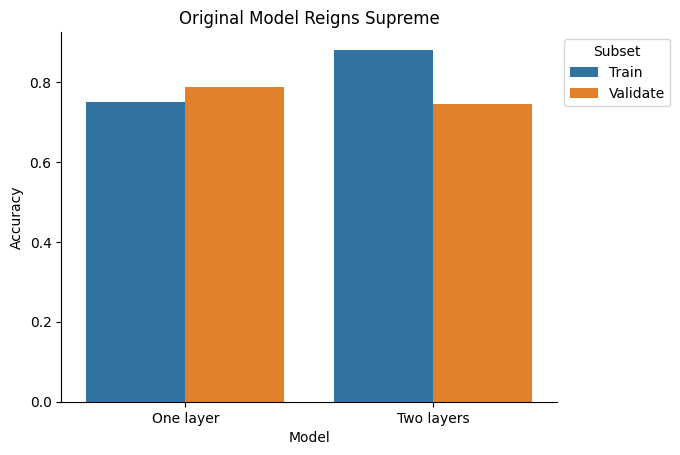

In [176]:
#plot
bar_chart(two_gru)
plt.title('Original Model Reigns Supreme')
plt.show()

As before, the original model outperforms the deeper model with an additional GRU layer. The deeper model appears to have issues with overfitting immediately. This could be a sign to introduce small amounts of regularization (in the form of dropout) to my models. In my next series of trials, I will combine optimization for two hyperparameters: increasing the size/number of dense layers and introducing dropout. I want to see if I can slow down this overfitting machine.

- Increasing/decreasing size of GRU layer
- Adding second GRU layer
- **Increasing size/number of dense layers**
- **Introduce small amount of regularization (dropout)**

In [177]:
#define basic model
gruod = keras.Sequential([
    layers.Embedding(vocab_size, 16),
    layers.GRU(32, activation='leaky_relu'),
    layers.Dense(16, activation='leaky_relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])
#compile and train
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
gruod.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gruod_hist = gru.fit(padded, df.target, batch_size=128, epochs=100, validation_split=0.2, verbose=0, callbacks=[callback])

Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


In [178]:
#define basic model
grubd = keras.Sequential([
    layers.Embedding(vocab_size, 16),
    layers.GRU(32, activation='leaky_relu'),
    layers.Dense(32, activation='leaky_relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])
#compile and train
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
grubd.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
grubd_hist = gru.fit(padded, df.target, batch_size=128, epochs=100, validation_split=0.2, verbose=0, callbacks=[callback])

Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


In [179]:
#define basic model
grudd = keras.Sequential([
    layers.Embedding(vocab_size, 16),
    layers.GRU(32, activation='leaky_relu'),
    layers.Dense(16, activation='leaky_relu'),
    layers.Dropout(0.2),
    layers.Dense(8, activation='leaky_relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])
#compile and train
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
grudd.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
grudd_hist = gru.fit(padded, df.target, batch_size=128, epochs=100, validation_split=0.2, verbose=0, callbacks=[callback])

Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


In [180]:
#generate dataframe
dropout = get_perf([gru_hist, gruod_hist, grubd_hist, grudd_hist], ['Original', 'Original Dropout', 'Large Dense', 'Double Dense'])
dropout

,Model,Subset,Accuracy
0,Original,Train,0.750903
1,Original,Validate,0.788575
2,Original Dropout,Train,0.884565
3,Original Dropout,Validate,0.730138
4,Large Dense,Train,0.878982
5,Large Dense,Validate,0.743270
6,Double Dense,Train,0.883744
7,Double Dense,Validate,0.725542


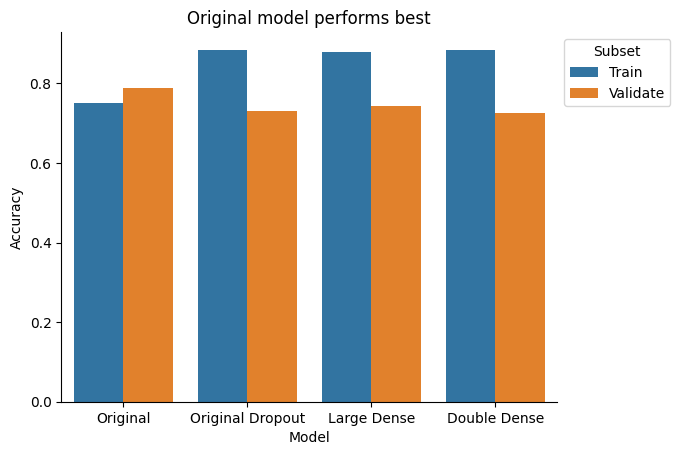

In [181]:
#plot
bar_chart(dropout)
plt.title('Original model performs best')
plt.show()

For some reason, every model with dropout included shows worse signs of overfitting. Even the original model with some dropout performs worse on the out-of-sample dataset.

## Results and analysis

To summarize, I tried many different model architectures and hyperparameters. I tried GRU, LSTM, and bi-directional LSTM layers. The base GRU layer performed best. Note: it may not appear to have performed best in the initial stage of hyperparameter tuning. The success of the GRU model was determined by its ability to generate useful predictions on the test set. I tried adding an GRU layer and increasing/decreasing the size of the lone GRU layer. I tried increasing/decreasing the size and number of the dense layers to no avail. And I tried introducing dropout into a variety of models. None of these variations outperformed the basic GRU model I created at the beginning of my modeling section. I will reiterate my best model's architecture below before I read in, prepare, and predict over the test data to make a submission to kaggle.

Best LSTM model:
- Embedding (vocab size, 16)
- GRU (32, leaky relu)
- Dense (16, leaky relu)
- Dense (1, sigmoid)

In [182]:
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [183]:
#lowercase text
test.text = test.text.str.lower()
#remove all but letters and spaces
test.text = test.text.str.replace(regexp, '', regex=True)
#call function to lemmatize the text
test.text = test.text.apply(prepare_text)
#convert words to numbers and pad
test_seqs = tknzr.texts_to_sequences(test.text)
test_pad = pad_sequences(test_seqs, padding='post', maxlen=seq_length)

In [188]:
#generate preds and add to test dataframe
preds = gru.predict(test_pad)
final_preds = np.where(preds >- 0.5, 1, 0)
test['target'] = final_preds
test.head()

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,id,keyword,location,text,target
0,0,NaN,NaN,happened terrible car crash,1
1,2,NaN,NaN,heard earthquake different city stay safe ever...,1
2,3,NaN,NaN,forest fire spot pond goose fleeing across str...,1
3,9,NaN,NaN,apocalypse lighting spokane wildfire,1
4,11,NaN,NaN,typhoon soudelor kill china taiwan,1


As you can see, switching to the GRU model was the correct decision. The text is talking about car crashes, earthquakes, forest fires, and typhoons! These are correctly classified as disasters by my model. I will clean it up and submit it to kaggle to receive a score!

In [189]:
#clean up dataframe
submission = test[['id', 'target']].set_index('id')
submission.head()

,target
id,
0,1
2,1
3,1
9,1
11,1


In [190]:
#save submission file
submission.to_csv('submission.csv')

My submission scored terribly - an F1 score of 0.43. I am only above the people who scored nothing at all on the leaderboard.

## Conclusion

In conclusion, my project was a bit of a rollercoaster. I enjoyed cleaning the data and looking at commonly occurring phrases in the dataset. I found that many disaster tweets were about suicide bombings and wildfires in California. I found that the tweets NOT discussing disasters were about social media and the stock market. I trained a variety of models: GRU, LSTM, and bi-directional LSTM. I found GRU to give the most useful predictions so I used it for hyperparameter tuning. I tried to change a number of hyperparameters for my model: size and number of GRU layers, size and number of dense layers, and introducing dropout. I found that none of these changes improved upon my original model. I used this model to predict on the test set and submit my predictions to kaggle. I received an F1 score of 0.43 - the lowest score on the leaderboard above 0! Clearly, I did not complete this assignment well.

Why didn't it work? I think I should have looked for better ways to generate word embeddings for my dataset. I used an embeddings layer for my deep learning models which I think failed to capture the meaning of the tweets. I think it also may not have worked because I should have trained the models for longer with much greater patience. Maybe I would have seen improvement in performance after many epochs. I learned it is very important to check what your model predicts early into the model selection process. Some of the predictions are indistinguishable from each other. This is an indication that the model may need to be trained longer or it may not be the correct model for the job.

To improve my project in the future, I would find a way to use transfer learning to generate better embeddings for my text data. I think that would improve the predictive power of my models. I would train my models for much longer and make them deeper to see the effects of longer training sessions. And I will continue to learn the best methods for handling text data with deep learning.